In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from my_ANN import initialize_params, forward, compute_cost, backward, update_params, predict

# Learning Rate Decay

### Decay on Every Iteration

$$\alpha = \frac{1}{1 + decayRate \times epochNumber} \alpha_{0}$$

In [2]:
def decay_every_iteration(initial_learning_rate, decay_rate, epoch_num):
    learning_rate = initial_learning_rate / (1 + decay_rate * epoch_num)
    return learning_rate

Notice that if you set the decay to occur at every iteration, the learning rate goes to zero too quickly - even if you start with a higher learning rate. 
<table> 
    <tr>
        <td>
        <b>Epoch Number</b>
        </td>
        <td>
        <b>Learning Rate</b>
        </td>
        <td>
        <b>Cost</b>
        </td>
    </tr>
    <tr>
        <td>
        0
        </td>
        <td>
        0.100000
        </td>
        <td>
        0.701091
        </td>
    </tr>
    <tr>
        <td>
        1000
        </td>
        <td>
        0.000100
        </td>
        <td>
        0.661884
        </td>
    </tr>
    <tr>
        <td>
        2000
        </td>
        <td>
        0.000050
        </td>
        <td>
        0.658620
        </td>
    </tr>
    <tr>
        <td>
        3000
        </td>
        <td>
        0.000033
        </td>
        <td>
        0.656765
        </td>
    </tr>
    <tr>
        <td>
        4000
        </td>
        <td>
        0.000025
        </td>
        <td>
        0.655486
        </td>
    </tr>
    <tr>
        <td>
        5000
        </td>
        <td>
        0.000020
        </td>
        <td>
        0.654514
        </td>
    </tr>
</table> 

When you're training for a few epoch this doesn't cause a lot of troubles, but when the number of epochs is large the optimization algorithm will stop updating. One common fix to this issue is to decay the learning rate every few steps. This is called fixed interval scheduling.

### Fixed Interval Scheduling

You can help prevent the learning rate speeding to zero too quickly by scheduling the exponential learning rate decay at a fixed time interval, for example 1000. You can either number the intervals, or divide the epoch by the time interval, which is the size of window with the constant learning rate. 

$$\alpha = \frac{1}{1 + decayRate \times \lfloor\frac{epochNum}{timeInterval}\rfloor} \alpha_{0}$$

**Note:** The fraction in the denominator uses the floor operation.

In [3]:
np.floor(1500/1000)

1.0

In [4]:
def decay_with_schedule(initial_learning_rate, decay_rate, epoch_num, time_interval=1000):
    epoch_num_to_decay = np.floor(epoch_num / time_interval)
    learning_rate = initial_learning_rate / (1 + decay_rate * epoch_num_to_decay)
    return learning_rate

# Optimizer

### Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 


In [5]:
def init_momentum(params):
    L = len(params) // 2
    
    V = {}
    # Initialize velocity
    for i in range(1, L+1):
        V["dW" + str(i)] = np.zeros_like(params['W' + str(i)])
        V["dB" + str(i)] = np.zeros_like(params['B' + str(i)])
        
    return V

Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}$$

In [6]:
def update_params_using_momentum(params, grads, V, learning_rate=0.01, beta=0.9, biasCorrection_t=2):
    L = len(params) // 2
    
    V_corrected = {}  # no need to create a dict
    
    for i in range(1, L+1):
        # Update the velocity
        V["dW" + str(i)] = beta * V["dW" + str(i)] + (1 - beta) * grads['dW' + str(i)]
        V["dB" + str(i)] = beta * V["dB" + str(i)] + (1 - beta) * grads['dB' + str(i)]
        
        V_corrected["dW" + str(i)] = V["dW" + str(i)] / (1 - beta**biasCorrection_t)
        V_corrected["dB" + str(i)] = V["dB" + str(i)] / (1 - beta**biasCorrection_t)
        
        # Update parameters using Momentum
        params["W" + str(i)] = params["W" + str(i)] - learning_rate * V_corrected["dW" + str(i)]
        params["B" + str(i)] = params["B" + str(i)] - learning_rate * V_corrected["dB" + str(i)]

    return params

**Note that**:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update, because it takes the past gradients into account more. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might require trying several values to see what works best in terms of reducing the value of the cost function $J$. 

**What you should remember**:
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

### RMSprop

In [7]:
def init_RMSprop(params):
    L = len(params) // 2
    
    S = {}
    # Initialize squared gradient average
    for i in range(1, L+1):
        S["dW" + str(i)] = np.zeros_like(params['W' + str(i)])
        S["dB" + str(i)] = np.zeros_like(params['B' + str(i)])
        
    return S

In [8]:
def update_params_using_RMSprop(params, grads, S, learning_rate=0.01, beta=0.999, biasCorrection_t=2, epsilon=1e-8):
    L = len(params) // 2
    
    S_corrected = {}
    
    for i in range(1, L+1):
        # Update the squared gradients
        S["dW" + str(i)] = beta * S["dW" + str(i)] + (1 - beta) * np.square(grads['dW' + str(i)])
        S["dB" + str(i)] = beta * S["dB" + str(i)] + (1 - beta) * np.square(grads['dB' + str(i)])
        
        S_corrected["dW" + str(i)] = S["dW" + str(i)] / (1 - beta**biasCorrection_t)
        S_corrected["dB" + str(i)] = S["dB" + str(i)] / (1 - beta**biasCorrection_t)
        
        # Update parameters using RMSprop
        params["W" + str(i)] = params["W" + str(i)] - learning_rate * grads['dW' + str(i)] / (np.sqrt(S_corrected["dW" + str(i)]) + epsilon)
        params["B" + str(i)] = params["B" + str(i)] - learning_rate * grads['dB' + str(i)] / (np.sqrt(S_corrected["dB" + str(i)]) + epsilon)

    return params

### Adam

In [9]:
def update_params_using_adam(
    params, grads, V, S, 
    learning_rate=0.01,
    beta1=0.9, beta2=0.99, biasCorrection_t=2, epsilon=1e-8
):
    
    L = len(params) // 2
    
    V_corrected = {}  # no need to create a dict
    S_corrected = {}
    
    for i in range(1, L+1):
        # Update first-moment estimate (velocity)
        V["dW" + str(i)] = beta1 * V["dW" + str(i)] + (1 - beta1) * grads['dW' + str(i)]
        V["dB" + str(i)] = beta1 * V["dB" + str(i)] + (1 - beta1) * grads['dB' + str(i)]
        
        # Update second-moment estimate (squared gradients)
        S["dW" + str(i)] = beta2 * S["dW" + str(i)] + (1 - beta2) * np.square(grads['dW' + str(i)])
        S["dB" + str(i)] = beta2 * S["dB" + str(i)] + (1 - beta2) * np.square(grads['dB' + str(i)])
        
        # Bias-corrected first-moment estimate
        V_corrected["dW" + str(i)] = V["dW" + str(i)] / (1 - beta1**biasCorrection_t)
        V_corrected["dB" + str(i)] = V["dB" + str(i)] / (1 - beta1**biasCorrection_t)
        
        # Bias-corrected second-moment estimate
        S_corrected["dW" + str(i)] = S["dW" + str(i)] / (1 - beta2**biasCorrection_t)
        S_corrected["dB" + str(i)] = S["dB" + str(i)] / (1 - beta2**biasCorrection_t)
        
        # Update parameters
        params["W" + str(i)] = params["W" + str(i)] - learning_rate * V_corrected["dW" + str(i)] / (np.sqrt(S_corrected["dW" + str(i)]) + epsilon)
        params["B" + str(i)] = params["B" + str(i)] - learning_rate * V_corrected["dB" + str(i)] / (np.sqrt(S_corrected["dB" + str(i)]) + epsilon)
    
    return params

# Types of Gradient Descent

### Batch Gradient Descent

In [10]:
def GD(X, Y, layers, learning_rate, epochs):
    """
    X: (n_features, n_samples)
    Y: (1, n_samples)
    layers: list[int]
    """
    costs = []
    
    # Init params
    params = initialize_params(layers)
    
    # Training all samples each epoch
    for i in range(1, epochs+1):
        # Forward pass
        Y_pred, caches = forward(X, params)
        # Compute cost
        cost = compute_cost(Y_pred, Y)
        costs.append(cost)
        # Backward pass to compute gradients
        grads = backward(Y, Y_pred, caches)
        # Update parameters
        params = update_params(params, grads, learning_rate)
        
        # Print cost
        if i % 100 == 0 or i == 1:
            print('Cost after Epoch {}: {}'.format(i, cost))

    return params, costs

### Stochastic Gradient Descent

In [11]:
def SGD(X, Y, layers, learning_rate, epochs):
    """
    X: (n_features, n_samples)
    Y: (1, n_samples)
    layers: list[int]
    """
    costs = []
    n_samples = X.shape[1]
    
    # Initialize parameters
    params = initialize_params(layers)
    
    # Training loop
    for i in range(1, epochs+1):
        total_cost = 0
        
        # Training each sample at a time
        for j in range(0, n_samples):
            # Forward pass
            Y_pred, caches = forward(X[:, j], params)
            # Compute cost
            cost_each_sample = compute_cost(Y_pred, Y[:, j])
            total_cost += cost_each_sample
            # Backward pass to compute gradients
            grads = backward(Y[:, j], Y_pred, caches)
            # Update parameters
            params = update_params(params, grads, learning_rate)
        
        # Compute the average cost per epoch
        avg_cost = total_cost / n_samples
        costs.append(avg_cost)
        
        # Print cost
        if i % 100 == 0 or i == 1:
            print('Cost after Epoch {}: {}'.format(i, avg_cost))

    return params, costs

### Mini-Batch Gradient Descent

In [12]:
np.random.permutation(5)

array([4, 2, 0, 1, 3])

In [13]:
def get_miniBatches(X, Y, batch_size=64, seed=0):
    np.random.seed(seed)

    mini_batches = []
    
    n_samples = X.shape[1]
    n_full_batches = n_samples // batch_size
    
    # Shuffle X, Y
    idx_permuted = np.random.permutation(n_samples)
    X_shuffled = X[:, idx_permuted]
    Y_shuffled = Y[:, idx_permuted]

    # Get mini_batches, each has <batch_size> samples
    for i in range(0, n_full_batches):
        start_idx = i * batch_size
        end_idx = (i+1) * batch_size
        
        batch_X = X_shuffled[:, start_idx: end_idx]
        batch_Y = Y_shuffled[:, start_idx: end_idx]
    
        batch = (batch_X, batch_Y)
        mini_batches.append(batch)

    # The remaining samples will be put into a batch with a smaller size
    if n_samples % batch_size != 0:
        start_idx = n_full_batches * batch_size
        
        batch_X = X_shuffled[:, start_idx: ]
        batch_Y = Y_shuffled[:, start_idx: ]
        
        batch = (batch_X, batch_Y)
        mini_batches.append(batch)

    return mini_batches

In [14]:
def MiniBatchGD(X, Y, layers, learning_rate, epochs, batch_size=64, seed=0):
    """
    X: (n_features, n_samples)
    Y: (1, n_samples)
    layers: list[int]
    batch_size: size of each mini-batch
    seed: random seed for shuffling data
    """
    costs = []
    n_samples = X.shape[1]
    
    # Initialize parameters
    params = initialize_params(layers)
    
    # Training
    for i in range(1, epochs + 1):
        total_cost = 0
        
        # Generate mini-batches
        mini_batches = get_miniBatches(X, Y, batch_size, seed)
        
        for batch_X, batch_Y in mini_batches:
            # Forward pass
            Y_pred, caches = forward(batch_X, params)
            # Compute cost
            avg_cost_each_batch = compute_cost(Y_pred, batch_Y)

            n_samples_each_batch = batch_Y.shape[1]
            total_cost_each_batch = n_samples_each_batch * avg_cost_each_batch
            
            total_cost += total_cost_each_batch
            # Backward pass to compute gradients
            grads = backward(batch_Y, Y_pred, caches)
            # Update parameters
            params = update_params(params, grads, learning_rate)
        
        # Compute the average cost per epoch
        avg_cost = total_cost / n_samples
        costs.append(avg_cost)
        
        # Print cost
        if i % 100 == 0 or i == 1:
            print('Cost after Epoch {}: {}'.format(i, avg_cost))

    return params, costs

# Now, Build a Complete Model

In [15]:
def model(
    X, Y, layers, 
    epochs=1000, batch_size=64, optimizer='adam',
    learning_rate=0.01, beta1=0.9, beta2=0.999, biasCorrection_t=2, epsilon=1e-8, 
    decay=True, decay_rate=0.1, time_interval=500
):
    
    n_samples = X.shape[1]

    costs = []
    learning_rates = []
    
    # Initialize parameters
    #np.random.seed(1)
    params = initialize_params(layers)
    
    #
    if optimizer == 'momentum':
        V = init_momentum(params)
    elif optimizer == 'rmsprop':
        S = init_RMSprop(params)
    elif optimizer == 'adam':
        V = init_momentum(params)
        S = init_RMSprop(params)
        
    # Training
    seed = 10
    for i in range(1, epochs + 1):
        total_cost = 0
        
        # Generate mini-batches
        seed += 1
        mini_batches = get_miniBatches(X, Y, batch_size, seed=seed)
        
        for batch_X, batch_Y in mini_batches:
            # Forward pass
            Y_pred, caches = forward(batch_X, params)
            
            # Compute cost
            avg_cost_each_batch = compute_cost(Y_pred, batch_Y)
            n_samples_each_batch = batch_Y.shape[1]
            
            total_cost_each_batch = n_samples_each_batch * avg_cost_each_batch
            total_cost += total_cost_each_batch
            
            # Backward pass to compute gradients
            grads = backward(batch_Y, Y_pred, caches)
            
            # Update parameters
            if optimizer == 'gd':
                params = update_params(params, grads, learning_rate)
            elif optimizer == 'momentum':
                params = update_params_using_momentum(params, grads, V, learning_rate, beta1, biasCorrection_t)
            elif optimizer == 'rmsprop':
                params = update_params_using_RMSprop(params, grads, S, learning_rate, beta2, biasCorrection_t, epsilon)
            elif optimizer == 'adam':
                params = update_params_using_adam(params, grads, V, S, learning_rate, 
                                                  beta1, beta2, biasCorrection_t, epsilon)
        
        # Compute the average cost per epoch
        avg_cost = total_cost / n_samples
        # Append cost per epoch to a list
        costs.append(avg_cost)

        # Decay learning rate
        if decay == True:
            learning_rate = decay_with_schedule(learning_rate, decay_rate, i, time_interval)
            # Append learning rate to a list
            learning_rates.append(learning_rate)
        
        # Print cost and learning rate
        if i % 500 == 0 or i == 1:
            print('{:<15} after Epoch {:<4}: {:<25}'.format('Cost', i, avg_cost))
            if decay == True:
                print('{:<15} after Epoch {:<4}: {:<25}'.format('Learning Rate', i, learning_rate))
            print('-'*15)
            
    return params, costs, learning_rates

In [16]:
def plot_costs(costs, title):
    plt.figure(figsize=(4,3))
    plt.plot(costs)
    
    plt.ylabel('Cost')
    plt.xlabel('Iterations (x300)')
    plt.title(title)
    
    plt.show()

In [17]:
def plot_costs(learning_rates, title):
    plt.figure(figsize=(4,3))
    plt.plot(learning_rates)
    
    plt.ylabel('Learning Rate')
    plt.xlabel('Iterations (x300)')
    plt.title(title)
    
    plt.show()

In [18]:
def plot_decision_boundary(X, y, params):
    """
    X: (n_features, n_samples)
    Y: (1, n_samples)
    """
    x1_min, x1_max = X[0, :].min() - 1, X[0, :].max() + 1
    x2_min, x2_max = X[1, :].min() - 1, X[1, :].max() + 1
    step = 0.01
    
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
    
    Y_pred = predict(np.c_[x1.ravel(), x2.ravel()].T, params)  # Y_pred shape (1, -1)
    Y_pred = Y_pred.reshape(x1.shape)
    
    plt.contourf(x1, x2, Y_pred, cmap=plt.cm.Spectral, alpha=0.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral, alpha=0.7)
    plt.show()

# Training

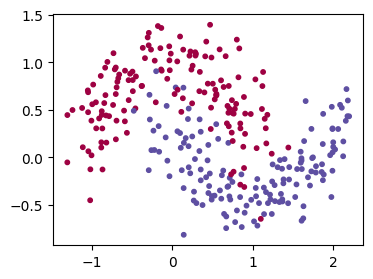

In [19]:
np.random.seed(3)
train_X, train_Y = datasets.make_moons(n_samples=300, noise=0.2)

plt.figure(figsize=(4,3))
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=10, cmap=plt.cm.Spectral);

In [20]:
train_X = train_X.T
train_Y = train_Y.reshape((1, -1))

train_X.shape, train_Y.shape

((2, 300), (1, 300))

In [21]:
layers = [train_X.shape[0], 5, 2, 1]

epochs = 2000
epochs_noDecay = 5000

batch_size = 64

learning_rate = 0.1
decay_rate = 0.1
time_interval = 1000

learning_rate_noDecay = 0.01

### Adam

In [22]:
params_adam, costs_adam, lrs_adam = model(train_X, train_Y, 
                                          layers=layers, 
                                          epochs=epochs, 
                                          batch_size=batch_size, 
                                          optimizer='adam', 
                                          learning_rate=learning_rate, 
                                          decay=True,
                                          decay_rate=decay_rate,
                                          time_interval=time_interval
                                         )

Cost            after Epoch 1   : 0.6023733472201829       
Learning Rate   after Epoch 1   : 0.1                      
---------------
Cost            after Epoch 500 : 0.12297131977513741      
Learning Rate   after Epoch 500 : 0.1                      
---------------
Cost            after Epoch 1000: 0.11766729713939182      
Learning Rate   after Epoch 1000: 0.09090909090909091      
---------------
Cost            after Epoch 1500: 0.11240608090492145      
Learning Rate   after Epoch 1500: 1.8292149228691006e-22   
---------------
Cost            after Epoch 2000: 0.11240608090492148      
Learning Rate   after Epoch 2000: 3.3739107943307368e-43   
---------------


In [23]:
params_adam_noDecay, costs_adam_noDecay, _ = model(train_X, train_Y, 
                                                   layers=layers, 
                                                   epochs=epochs_noDecay, 
                                                   batch_size=batch_size, 
                                                   optimizer='adam', 
                                                   learning_rate=learning_rate_noDecay, 
                                                   decay=False
                                                  )

Cost            after Epoch 1   : 0.7156708098420522       
---------------
Cost            after Epoch 500 : 0.1414956631854207       
---------------
Cost            after Epoch 1000: 0.13759208385047286      
---------------
Cost            after Epoch 1500: 0.13707086527577797      
---------------
Cost            after Epoch 2000: 0.13669451928294707      
---------------
Cost            after Epoch 2500: 0.13642474569351398      
---------------
Cost            after Epoch 3000: 0.13662351214196808      
---------------
Cost            after Epoch 3500: 0.13647069468735773      
---------------
Cost            after Epoch 4000: 0.1365118300669121       
---------------
Cost            after Epoch 4500: 0.13644532742124316      
---------------
Cost            after Epoch 5000: 0.13646269755555232      
---------------


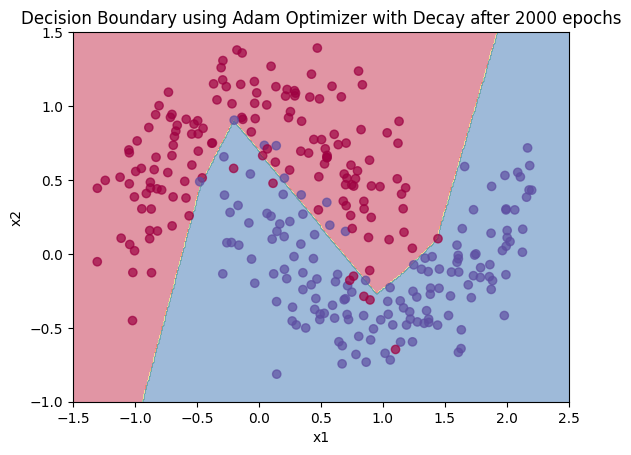

In [24]:
plt.title("Decision Boundary using Adam Optimizer with Decay after {} epochs".format(epochs))
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(train_X, train_Y, params_adam)

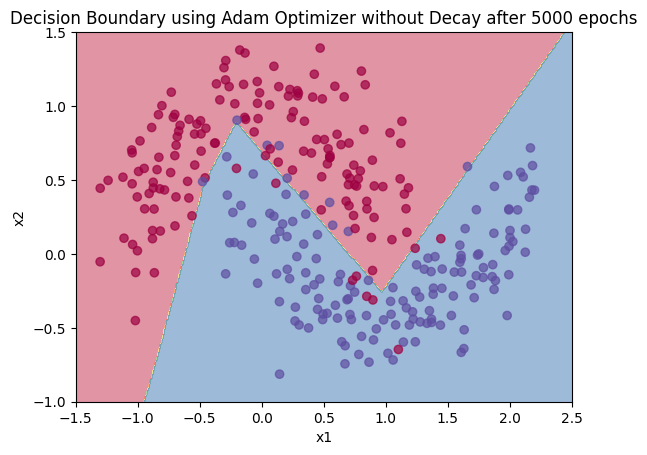

In [25]:
plt.title("Decision Boundary using Adam Optimizer without Decay after {} epochs".format(epochs_noDecay))
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(train_X, train_Y, params_adam_noDecay)

### Momentum

In [26]:
params_mmt, costs_mmt, lrs_mmt = model(train_X, train_Y, 
                                       layers=layers, 
                                       epochs=epochs, 
                                       batch_size=batch_size, 
                                       optimizer='momentum', 
                                       learning_rate=learning_rate, 
                                       decay=True,
                                       decay_rate=decay_rate,
                                       time_interval=time_interval
                                      )

Cost            after Epoch 1   : 0.6976496616138044       
Learning Rate   after Epoch 1   : 0.1                      
---------------
Cost            after Epoch 500 : 0.13889844419977318      
Learning Rate   after Epoch 500 : 0.1                      
---------------
Cost            after Epoch 1000: 0.1326092183239532       
Learning Rate   after Epoch 1000: 0.09090909090909091      
---------------
Cost            after Epoch 1500: 0.12725660845218267      
Learning Rate   after Epoch 1500: 1.8292149228691006e-22   
---------------
Cost            after Epoch 2000: 0.12725660845218267      
Learning Rate   after Epoch 2000: 3.3739107943307368e-43   
---------------


In [27]:
params_mmt_noDecay, costs_mmt_noDecay, _ = model(train_X, train_Y, 
                                                 layers=layers, 
                                                 epochs=epochs_noDecay, 
                                                 batch_size=batch_size, 
                                                 optimizer='momentum', 
                                                 learning_rate=learning_rate_noDecay, 
                                                 decay=False
                                                )

Cost            after Epoch 1   : 0.7234253604841385       
---------------
Cost            after Epoch 500 : 0.23123679780381848      
---------------
Cost            after Epoch 1000: 0.14188288751684033      
---------------
Cost            after Epoch 1500: 0.13997669658790513      
---------------
Cost            after Epoch 2000: 0.13947454566175185      
---------------
Cost            after Epoch 2500: 0.13890561991011643      
---------------
Cost            after Epoch 3000: 0.13964508344143584      
---------------
Cost            after Epoch 3500: 0.13929507644332265      
---------------
Cost            after Epoch 4000: 0.13962799634058762      
---------------
Cost            after Epoch 4500: 0.13932053789010393      
---------------
Cost            after Epoch 5000: 0.13927003900448445      
---------------


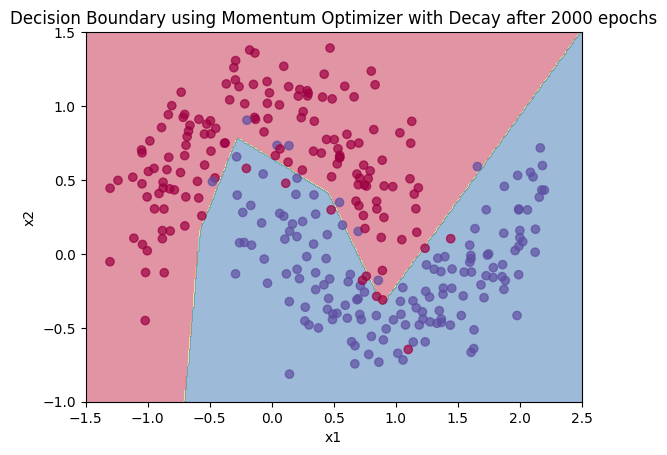

In [28]:
plt.title("Decision Boundary using Momentum Optimizer with Decay after {} epochs".format(epochs))
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(train_X, train_Y, params_mmt)

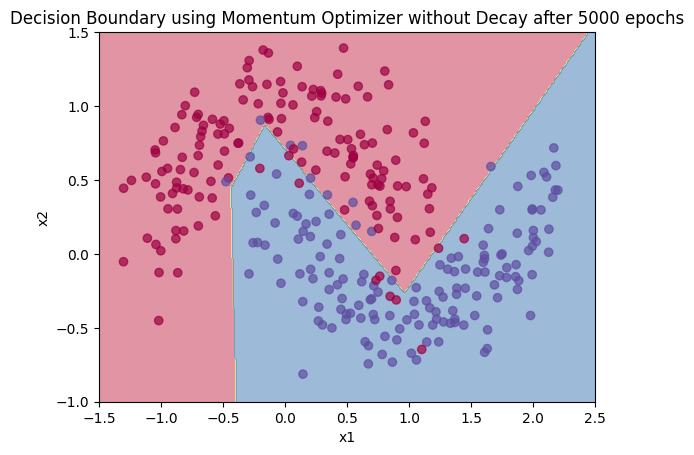

In [29]:
plt.title("Decision Boundary using Momentum Optimizer without Decay after {} epochs".format(epochs_noDecay))
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(train_X, train_Y, params_mmt_noDecay)

### RMSprop

In [30]:
params_rms, costs_rms, lrs_rms = model(train_X, train_Y, 
                                       layers=layers, 
                                       epochs=epochs, 
                                       batch_size=batch_size, 
                                       optimizer='rmsprop', 
                                       learning_rate=learning_rate, 
                                       decay=True, 
                                       decay_rate=decay_rate,
                                       time_interval=time_interval
                                      )

Cost            after Epoch 1   : 0.6589400799105707       
Learning Rate   after Epoch 1   : 0.1                      
---------------
Cost            after Epoch 500 : 0.13694677346885334      
Learning Rate   after Epoch 500 : 0.1                      
---------------
Cost            after Epoch 1000: 0.13645529340840917      
Learning Rate   after Epoch 1000: 0.09090909090909091      
---------------
Cost            after Epoch 1500: 0.13361112558835495      
Learning Rate   after Epoch 1500: 1.8292149228691006e-22   
---------------
Cost            after Epoch 2000: 0.13361112558835497      
Learning Rate   after Epoch 2000: 3.3739107943307368e-43   
---------------


In [31]:
params_rms_noDecay, costs_rms_noDecay, _ = model(train_X, train_Y, 
                                                 layers=layers, 
                                                 epochs=epochs_noDecay, 
                                                 batch_size=batch_size, 
                                                 optimizer='rmsprop', 
                                                 learning_rate=learning_rate_noDecay, 
                                                 decay=False)

Cost            after Epoch 1   : 0.7143697417669134       
---------------
Cost            after Epoch 500 : 0.2801252498125971       
---------------
Cost            after Epoch 1000: 0.20571827948095744      
---------------
Cost            after Epoch 1500: 0.16583470439217643      
---------------
Cost            after Epoch 2000: 0.14473989259984452      
---------------
Cost            after Epoch 2500: 0.1351470347005035       
---------------
Cost            after Epoch 3000: 0.13114340083061216      
---------------
Cost            after Epoch 3500: 0.12953539456366067      
---------------
Cost            after Epoch 4000: 0.12879170869350168      
---------------
Cost            after Epoch 4500: 0.1275826649478815       
---------------
Cost            after Epoch 5000: 0.12723053963625822      
---------------


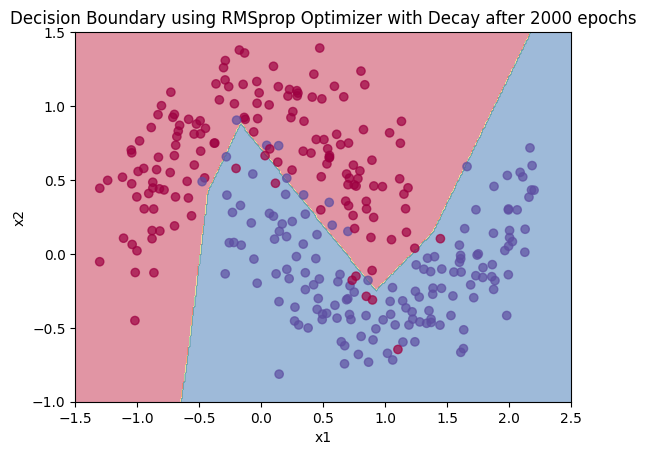

In [32]:
plt.title("Decision Boundary using RMSprop Optimizer with Decay after {} epochs".format(epochs))
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(train_X, train_Y, params_rms)

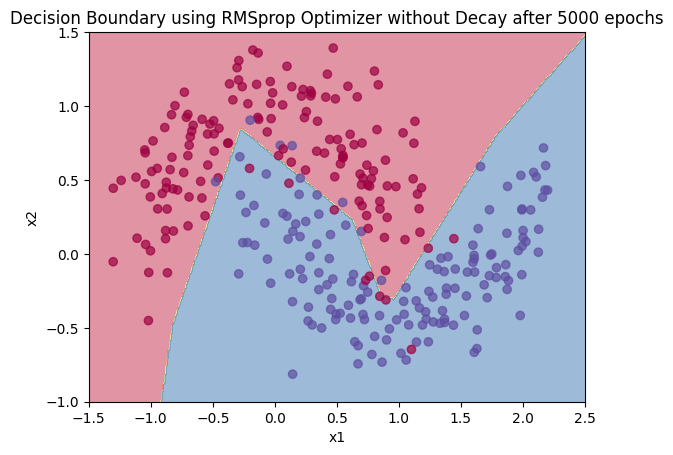

In [33]:
plt.title("Decision Boundary using RMSprop Optimizer without Decay after {} epochs".format(epochs_noDecay))
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(train_X, train_Y, params_rms_noDecay)